In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

7580


In [2]:
import cv2
from tqdm import tqdm

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 396


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [5]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed


# Part 2: watershed

In [11]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
        
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_0.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_1.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_2.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_3.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_4.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_5.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_6.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershe

\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_339.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_340.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_341.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_342.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_343.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_344.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segmentation\watershed\segmentation_label_345.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_0\20221025-hM1_hM1_Cx28_sample3\Segment

<IPython.core.display.Javascript object>


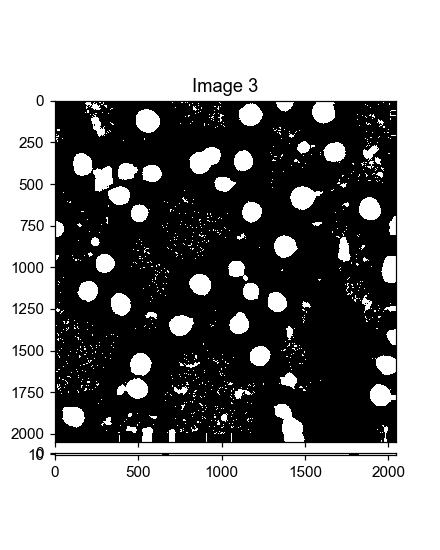

In [11]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


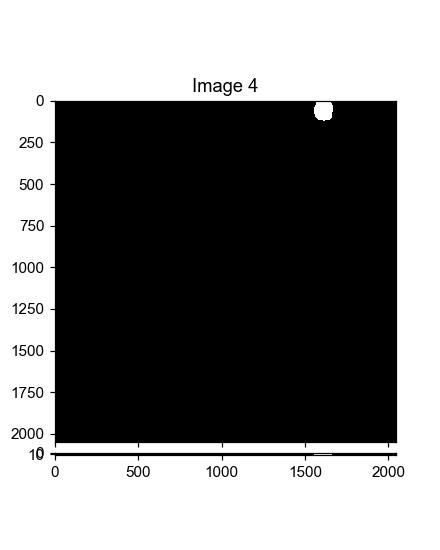

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels, corr_labels3d==1])